In [1]:
!pip install imageio

!pip install tf-nightly-gpu-2.0-preview

import tensorflow as tf

print("You have version", tf.__version__)
assert tf.__version__ >= "2.0" # TensorFlow ≥ 2.0 required

from __future__ import absolute_import, division, print_function

import glob
import matplotlib.pyplot as plt
import numpy as np
import os,itertools, imageio, pickle
import PIL
import tensorflow.keras.layers as layers
import time


from IPython import display

from google.colab import drive

drive.mount('/content/gdrive')

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]



def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
      
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)  
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
  
    return model
  
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', 
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
      
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
       
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
     
    return model
  

  
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)




def generate_and_save_images(model, epoch, test_input,show = False, save = False,path = 'result.png' ):
  # Notice `training` is set to False. 
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
        
  if save:
        plt.savefig(path)

  if show:
      plt.show()
  else:
      plt.close()
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  
  
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

    100% |████████████████████████████████| 336.9MB 70kB/s 
    100% |████████████████████████████████| 61kB 24.1MB/s 
    100% |████████████████████████████████| 358kB 13.1MB/s 
    100% |████████████████████████████████| 3.0MB 8.2MB/s 
You have version 2.0.0-dev20190312
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
11493376/11490434 [==============================] - 0s 0us/step


In [7]:
BUFFER_SIZE = [60000]
BATCH_SIZE = 256
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

for bf in BUFFER_SIZE:
  print("starting new buffer of size %d " % bf)
  train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(bf).batch(BATCH_SIZE)

  generator = make_generator_model()

  noise = tf.random.normal([1, 100])
  generated_image = generator(noise, training=False)

  #plt.imshow(generated_image[0, :, :, 0], cmap='gray')

  discriminator = make_discriminator_model()
  decision = discriminator(generated_image)
  #print (decision)

  checkpoint_dir = F"/content/gdrive/My Drive/DCGANs/training_checkpoints/" + str(bf) +'buff/'
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                   discriminator_optimizer=discriminator_optimizer,
                                   generator=generator,
                                   discriminator=discriminator)


  seed = tf.random.normal([num_examples_to_generate, noise_dim])

  root = F"/content/gdrive/My Drive/DCGANs/" + str(bf) + "buff/"
  model = 'MNIST_DCGAN_'
  if not os.path.isdir(root):
      os.mkdir(root)
  if not os.path.isdir(root + 'Fixed_results'):
      os.mkdir(root + 'Fixed_results')

  train_hist = {}
  train_hist['D_losses'] = []
  train_hist['G_losses'] = []
  train_hist['per_epoch_ptimes'] = []
  train_hist['total_ptime'] = []


  start_time = time.time()
  #train(train_dataset, EPOCHS)
  for epoch in range(EPOCHS):
    G_losses = []
    D_losses = []
    epoch_start_time = time.time()

    for image_batch in train_dataset:
      noise = tf.random.normal([bf, noise_dim])

      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(image_batch, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        G_losses.append(gen_loss)
        disc_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) + cross_entropy(tf.ones_like(real_output), real_output)
        D_losses.append(disc_loss)

      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Produce images for the GIF as we go
   # display.clear_output(wait=True)
    fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + '.png'
    generate_and_save_images(generator, epoch + 1, seed,show = False, save=True, path=fixed_p)

    # Save the model every 15 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print('[%d/%d] - ptime: %.2f loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), EPOCHS, per_epoch_ptime, np.mean(D_losses), np.mean(G_losses)))
    train_hist['D_losses'].append(np.mean(D_losses))
    train_hist['G_losses'].append(np.mean(G_losses))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

    #print ('Time for epoch {} is {} sec'.format(epoch + 1, per_epoch_ptime))

  end_time = time.time()
  total_ptime = end_time - start_time
  train_hist['total_ptime'].append(total_ptime)
  # Generate after the final epoch
  display.clear_output(wait=True)
  fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + 'final.png'
  #generate_and_save_images(generator, EPOCHS, seed,show = False, save=True, path=fixed_p)

  print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (np.mean(train_hist['per_epoch_ptimes']), EPOCHS, total_ptime))
  print("Training finish!... save training results")

  with open(root + model + 'train_hist.pkl', 'wb') as f:
      pickle.dump(train_hist, f)

  fixed_h = root + 'Fixed_results/' + model + str(epoch + 1) + 'train_hist.png'
  show_train_hist(train_hist, save=True, path=fixed_h)

  show_train_hist(train_hist,show = True, save=True, path=root + model + 'train_hist.png')

  """Restore the latest checkpoint."""

  #checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

  display_image(EPOCHS)

  """Use `imageio` to create an animated gif using the images saved during training."""

  with imageio.get_writer(root + model + 'dcgan.gif', mode='I') as writer:
    filenames = glob.glob(root + model + '*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
      frame = 2*(i**0.5)
      if round(frame) > round(last):
        last = frame
      else:
        continue
      image = imageio.imread(filename)
      writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

  # A hack to display the GIF inside this notebook
  os.rename(root + model + 'dcgan.gif', root + model + 'dcgan.gif.png')

  name = root + model + 'train_hist' + str(bf) + '.txt'

  f = open(name,'w')
  f.write(str(train_hist))
  f.close()
  
  
  """Display the animated gif with all the images generated during the training of GANs."""

  images = []
  for e in range(EPOCHS):
      img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
      images.append(imageio.imread(img_name))
  imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)


  display.Image(filename=root + model + "dcgan.gif.png")




starting new buffer of size 60000 


ResourceExhaustedError: ignored

In [2]:
BUFFER_SIZE = 60000
BATCH_SIZE = [256]
EPOCHS = 25
noise_dim = 100
num_examples_to_generate = 16

for bs in BATCH_SIZE:
  print("starting new batch of size %d " % bs)
  train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(bs)

  generator = make_generator_model()

  noise = tf.random.normal([1, 100])
  generated_image = generator(noise, training=False)

  #plt.imshow(generated_image[0, :, :, 0], cmap='gray')

  discriminator = make_discriminator_model()
  decision = discriminator(generated_image)
  #print (decision)

  checkpoint_dir = F"/content/gdrive/My Drive/DCGANs/training_checkpoints/" + str(bs) +'/'
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                   discriminator_optimizer=discriminator_optimizer,
                                   generator=generator,
                                   discriminator=discriminator)


  seed = tf.random.normal([num_examples_to_generate, noise_dim])

  root = F"/content/gdrive/My Drive/DCGANs/" + str(bs) + "/"
  model = 'MNIST_DCGAN_'
  if not os.path.isdir(root):
      os.mkdir(root)
  if not os.path.isdir(root + 'Fixed_results'):
      os.mkdir(root + 'Fixed_results')

  train_hist = {}
  train_hist['D_losses'] = []
  train_hist['G_losses'] = []
  train_hist['per_epoch_ptimes'] = []
  train_hist['total_ptime'] = []


  start_time = time.time()
  #train(train_dataset, EPOCHS)
  for epoch in range(EPOCHS):
    G_losses = []
    D_losses = []
    epoch_start_time = time.time()

    for image_batch in train_dataset:
      noise = tf.random.normal([bs, noise_dim])

      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(image_batch, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        G_losses.append(gen_loss)
        disc_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) + cross_entropy(tf.ones_like(real_output), real_output)
        D_losses.append(disc_loss)

      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Produce images for the GIF as we go
   # display.clear_output(wait=True)
    fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + '.png'
    generate_and_save_images(generator, epoch + 1, seed,show = False, save=True, path=fixed_p)

    # Save the model every 15 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print('[%d/%d] - ptime: %.2f loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), EPOCHS, per_epoch_ptime, np.mean(D_losses), np.mean(G_losses)))
    train_hist['D_losses'].append(np.mean(D_losses))
    train_hist['G_losses'].append(np.mean(G_losses))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

    #print ('Time for epoch {} is {} sec'.format(epoch + 1, per_epoch_ptime))

  end_time = time.time()
  total_ptime = end_time - start_time
  train_hist['total_ptime'].append(total_ptime)
  # Generate after the final epoch
  display.clear_output(wait=True)
  fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + 'final.png'
  #generate_and_save_images(generator, EPOCHS, seed,show = False, save=True, path=fixed_p)

  print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (np.mean(train_hist['per_epoch_ptimes']), EPOCHS, total_ptime))
  print("Training finish!... save training results")

  with open(root + model + 'train_hist.pkl', 'wb') as f:
      pickle.dump(train_hist, f)

  fixed_h = root + 'Fixed_results/' + model + str(epoch + 1) + 'train_hist.png'
  show_train_hist(train_hist, save=True, path=fixed_h)

  show_train_hist(train_hist,show = True, save=True, path=root + model + 'train_hist.png')

  """Restore the latest checkpoint."""

  #checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

  display_image(EPOCHS)

  """Use `imageio` to create an animated gif using the images saved during training."""

  with imageio.get_writer(root + model + 'dcgan.gif', mode='I') as writer:
    filenames = glob.glob(root + model + '*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
      frame = 2*(i**0.5)
      if round(frame) > round(last):
        last = frame
      else:
        continue
      image = imageio.imread(filename)
      writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

  # A hack to display the GIF inside this notebook
  os.rename(root + model + 'dcgan.gif', root + model + 'dcgan.gif.png')

  name = root + model + 'train_hist' + str(bs) + '.txt'

  f = open(name,'w')
  f.write(str(train_hist))
  f.close()
  
  
  """Display the animated gif with all the images generated during the training of GANs."""

  images = []
  for e in range(EPOCHS):
      img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
      images.append(imageio.imread(img_name))
  imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)


  display.Image(filename=root + model + "dcgan.gif.png")


starting new batch of size 256 


KeyboardInterrupt: ignored

Avg per epoch ptime: 42.54, total 200 epochs ptime: 8556.10
Training finish!... save training results


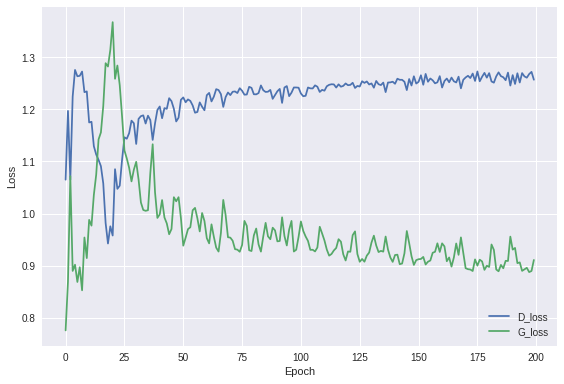

In [3]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = [200]
noise_dim = 100
num_examples_to_generate = 16

for ep in EPOCHS:
  print("starting new run of epochs %d " % ep)
  train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

  generator = make_generator_model()

  noise = tf.random.normal([1, 100])
  generated_image = generator(noise, training=False)

  #plt.imshow(generated_image[0, :, :, 0], cmap='gray')

  discriminator = make_discriminator_model()
  decision = discriminator(generated_image)
  #print (decision)

  checkpoint_dir = F"/content/gdrive/My Drive/DCGANs/training_checkpoints/" + str(ep) +'epochs/'
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                   discriminator_optimizer=discriminator_optimizer,
                                   generator=generator,
                                   discriminator=discriminator)


  seed = tf.random.normal([num_examples_to_generate, noise_dim])

  root = F"/content/gdrive/My Drive/DCGANs/" + str(ep) + "epochs/"
  model = 'MNIST_DCGAN_'
  if not os.path.isdir(root):
      os.mkdir(root)
  if not os.path.isdir(root + 'Fixed_results'):
      os.mkdir(root + 'Fixed_results')

  train_hist = {}
  train_hist['D_losses'] = []
  train_hist['G_losses'] = []
  train_hist['per_epoch_ptimes'] = []
  train_hist['total_ptime'] = []


  start_time = time.time()
  #train(train_dataset, ep)
  for epoch in range(ep):
    G_losses = []
    D_losses = []
    epoch_start_time = time.time()

    for image_batch in train_dataset:
      noise = tf.random.normal([BATCH_SIZE, noise_dim])

      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(image_batch, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        G_losses.append(gen_loss)
        disc_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) + cross_entropy(tf.ones_like(real_output), real_output)
        D_losses.append(disc_loss)

      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Produce images for the GIF as we go
   # display.clear_output(wait=True)
    fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + '.png'
    generate_and_save_images(generator, epoch + 1, seed,show = False, save=True, path=fixed_p)

    # Save the model every 15 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print('[%d/%d] - ptime: %.2f loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), ep, per_epoch_ptime, np.mean(D_losses), np.mean(G_losses)))
    train_hist['D_losses'].append(np.mean(D_losses))
    train_hist['G_losses'].append(np.mean(G_losses))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

    #print ('Time for epoch {} is {} sec'.format(epoch + 1, per_epoch_ptime))

  end_time = time.time()
  total_ptime = end_time - start_time
  train_hist['total_ptime'].append(total_ptime)
  # Generate after the final epoch
  display.clear_output(wait=True)
  fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + 'final.png'
  #generate_and_save_images(generator, ep, seed,show = False, save=True, path=fixed_p)

  print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (np.mean(train_hist['per_epoch_ptimes']), ep, total_ptime))
  print("Training finish!... save training results")


  fixed_h = root + 'Fixed_results/' + model + str(epoch + 1) + 'train_hist.png'
  show_train_hist(train_hist, save=True, path=fixed_h)

  show_train_hist(train_hist,show = True, save=True, path=root + model + 'train_hist.png')

  """Restore the latest checkpoint."""

  #checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

  display_image(ep)

  """Use `imageio` to create an animated gif using the images saved during training."""

  with imageio.get_writer(root + model + 'dcgan.gif', mode='I') as writer:
    filenames = glob.glob(root + model + '*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
      frame = 2*(i**0.5)
      if round(frame) > round(last):
        last = frame
      else:
        continue
      image = imageio.imread(filename)
      writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

  # A hack to display the GIF inside this notebook
  os.rename(root + model + 'dcgan.gif', root + model + 'dcgan.gif.png')

  name = root + model + 'train_hist' + str(ep) + 'epochs.txt'

  f = open(name,'w')
  f.write(str(train_hist))
  f.close()
  
  
  """Display the animated gif with all the images generated during the training of GANs."""

  images = []
  for e in range(ep):
      img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
      images.append(imageio.imread(img_name))
  imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)


  display.Image(filename=root + model + "dcgan.gif.png")
